# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


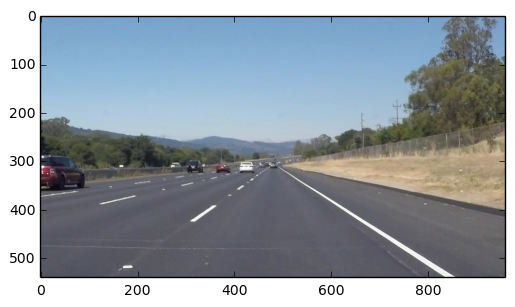

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image);  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Historic slope, intercepts for error correction
# If the variance in slope is greater than a treshold, 
# revert to historic values. Assuming they dont change rapidly
# under normal driving conditions
prev_lslope = 0.0
prev_rslope = 0.0
prev_lb = 0.0
prev_rb = 0.0

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #Global variables
    global prev_lslope
    global prev_rslope
    global prev_lb
    global prev_rb
     
    
    lslope = [] # left slope array
    lx = []
    ly = []
    rslope = [] # right slope array
    rx = []
    ry = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if not (x1 == x2):
                # Compute slope for each line and add it to lslope or rslope
                slope = (y2-y1)/(x2-x1)
                if (slope < -0.5):
                    rslope.append(slope)
                    rx.append(x1)
                    rx.append(x2)
                    ry.append(y1)
                    ry.append(y2)
                elif (slope > 0.5):
                    lslope.append(slope)
                    lx.append(x1)
                    lx.append(x2)
                    ly.append(y1)
                    ly.append(y2)
                
    # Compute top y value and bottom y value to exrapolate lines between these                 
    imshape = img.shape
    top_y = int(imshape[0]/2) + int(imshape[0]/20)
    bottom_y = imshape[0]             
        
    #Compute average slope of left lane
    #If no left lines were detected,
    #use historic value
    if lslope:
        avg_lslope = np.mean(lslope)
    else:
        avg_lslope = prev_lslope  
        
    #If the average slope variance is greater than a treshold,
    #reset average slope to historic value
    if not(prev_lslope == 0.0):
        if abs((prev_lslope - avg_lslope)/prev_lslope) >= 0.2:
            avg_lslope = prev_lslope
            
    #If no left lanes were detected, use historic value
    if lx and ly:       
        avg_lx = np.mean(lx)
        avg_ly = np.mean(ly)
        lb = avg_ly - avg_lslope * avg_lx
    else:
        lb = prev_lb
 
    """      
    if not(prev_lb == 0.0):
        if abs((prev_lb - lb)/prev_lb) >= 0.1:
            lb = prev_lb
    """
    
    #Draw left lane 
    #
    #ly1 = min(ly)
    ly1 = top_y
    #ly2 = max(ly)
    ly2 = bottom_y
  
    lx1 = int((ly1 - lb)/avg_lslope)
    lx2 = int((ly2 - lb)/avg_lslope)
    cv2.line(img, (lx1, ly1), (lx2, ly2), color, thickness)


        
    #Compute average slope of right lane
    #If no right lines were detected,
    #use historic value        
    if rslope:
        avg_rslope = np.mean(rslope)
    else:
        avg_rslope = prev_rslope  
    
    #If the average slope variance is greater than a treshold,
    #reset average slope to historic value
    if not(prev_rslope == 0.0):
        if abs((prev_rslope - avg_rslope)/prev_rslope) >= 0.2:
            avg_rslope = prev_rslope
    
    #If no right lanes were detected, use historic value
    if rx and ry:
        avg_rx = np.mean(rx)
        avg_ry = np.mean(ry)
        rb = avg_ry - avg_rslope * avg_rx
    else:
        rb = prev_rb
        
    """
    if not(prev_rb == 0.0):
        if abs((prev_rb - rb)/prev_rb) >= 0.001:
            rb = prev_rb
    """
        
    #Draw right lane 
    #
    #y1 = min(ry)
    ry1 = top_y
    #ry2 = max(ry)
    ry2 = bottom_y
  
    rx1 = int((ry1 - rb)/avg_rslope)
    rx2 = int((ry2 - rb)/avg_rslope) 
    cv2.line(img, (rx1, ry1), (rx2, ry2), color, thickness)

    
    prev_lslope = avg_lslope
    prev_rslope = avg_rslope
    prev_lb = lb
    prev_rb = rb
    
    """    
    prev_lslope = (prev_lslope + avg_lslope)/2.0
    prev_rslope = (prev_rslope + avg_rslope)/2.0
    prev_lb = (prev_lb + lb)/2.0
    prev_rb = (prev_rb + rb)/2.0
    """
    
    
    """     
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    """     
            
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros(img.shape, dtype=np.uint8)
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    draw_lines(line_image, lines)
    return line_image


# FOR TESTING: Draw all line segments from houg transform
def hough_lines1(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros(img.shape, dtype=np.uint8)
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    
    color=[255, 0, 0]
    thickness=8
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)
            
    return line_image




# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


In [4]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    
    # grayscale the image
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    """
    plt.figure()
    plt.imshow(gray, cmap='gray');
    """
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 200
    high_threshold = 200
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Define a four sided polygon to mask
    imshape = image.shape
    center_x = int(imshape[1]/2)
    center_y = int(imshape[0]/2) + int(imshape[0]/20) - 100
    left_x = max(0,center_x - 350)
    right_x = min(center_x + 450, imshape[1])
    
    bottom_y = imshape[0] - int(imshape[0]/10)
    
    vertices = np.array([[(left_x,bottom_y),
                          (center_x, center_y), 
                          (center_x, center_y), 
                          (right_x,bottom_y)]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 100   # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 180 #minimum number of pixels making up a line
    max_line_gap = 200  # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments       
    line_image =  hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)     

    """
    line_image1 =  hough_lines1(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    """
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    try:
        """        
        lines_edges = weighted_img(line_image1, color_edges, α=0.8, β=1., λ=0.)
        plt.figure()
        plt.imshow(lines_edges)
        
        lines_edges = weighted_img(line_image, color_edges, α=0.8, β=1., λ=0.)
        plt.figure()
        """
        
        lines_edges = weighted_img(line_image, image, α=0.8, β=1., λ=0.)
        
        """    
        plt.figure()
        """
        plt.imshow(lines_edges)
        
        x = [vertices[0][i][0] for i in range(len(vertices[0]))]
        y = [vertices[0][i][1] for i in range(len(vertices[0]))]
        x.append(x[0])
        y.append(y[0])
        plt.plot(x, y, 'b--', lw=4)
        

    except:
        lines_edges = image
    
    return lines_edges
    

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve2.jpg']

run your solution on all test_images and make copies into the test_images directory).

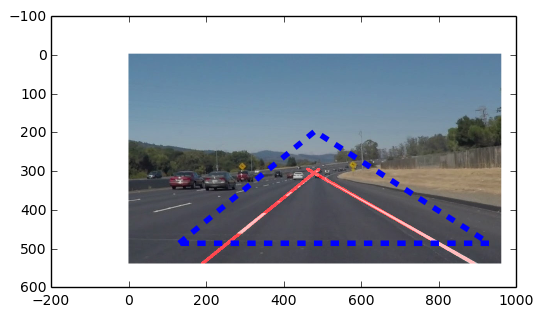

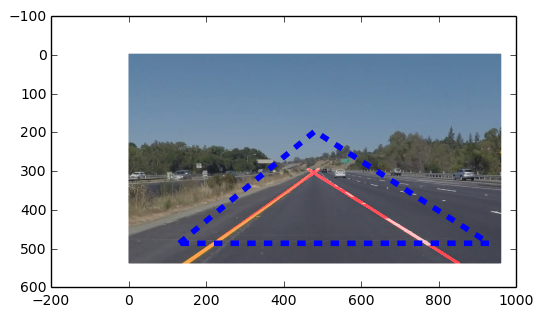

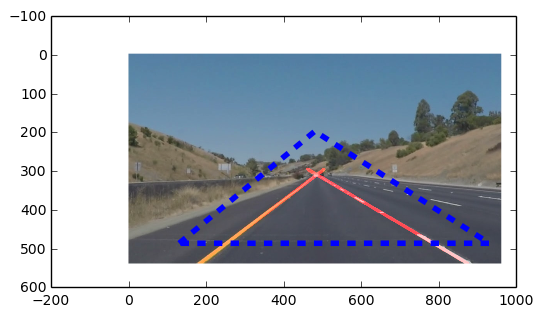

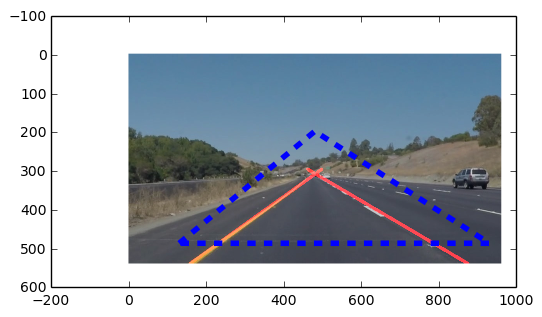

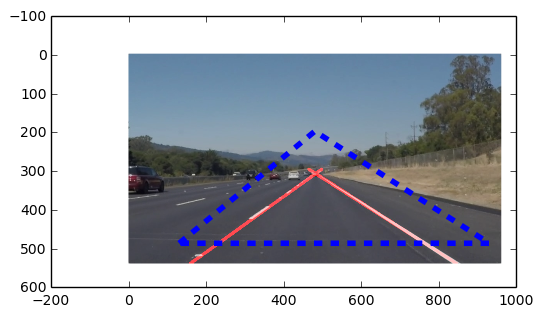

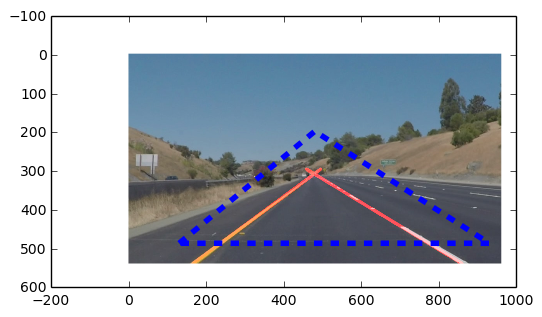

In [6]:
#Test!!!    
dir_name = "test_images/"
picl = os.listdir(dir_name)
for i in range(len(picl)):
    fname = dir_name+picl[i]
    #reading in an image
    image = mpimg.imread(fname)  
    process_image(image); 
    plt.figure();

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 34.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.16 s, sys: 264 ms, total: 6.42 s
Wall time: 6.74 s


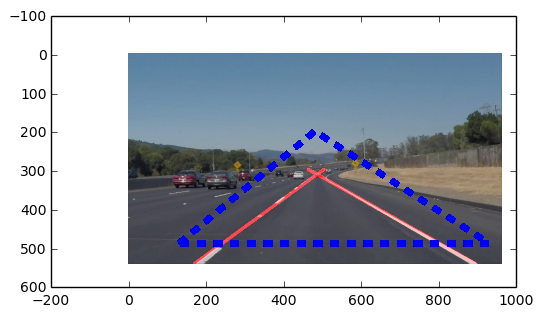

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image); #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:19<00:00, 34.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 19.2 s, sys: 724 ms, total: 20 s
Wall time: 20.3 s


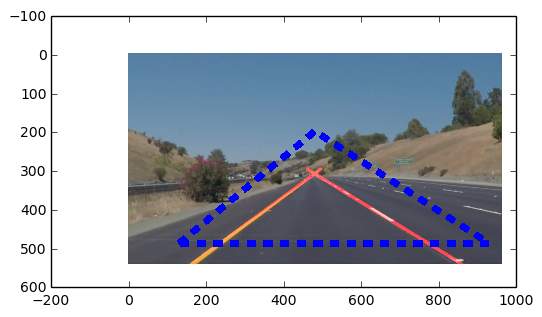

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Historic slope, intercepts for error correction
# If the variance in slope is greater than a treshold, 
# revert to historic values. Assuming they dont change rapidly
# under normal driving conditions
prev_lslope = 0.0
prev_rslope = 0.0
prev_lb = 0.0
prev_rb = 0.0

def draw_lines(img, lines, color=[255, 0, 0], thickness=8):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    #Global variables
    global prev_lslope
    global prev_rslope
    global prev_lb
    global prev_rb
     
    
    lslope = [] # left slope array
    lx = []
    ly = []
    rslope = [] # right slope array
    rx = []
    ry = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            if not (x1 == x2):
                # Compute slope for each line and add it to lslope or rslope
                slope = (y2-y1)/(x2-x1)
                if (slope < -0.5):
                    rslope.append(slope)
                    rx.append(x1)
                    rx.append(x2)
                    ry.append(y1)
                    ry.append(y2)
                elif (slope > 0.5):
                    lslope.append(slope)
                    lx.append(x1)
                    lx.append(x2)
                    ly.append(y1)
                    ly.append(y2)
                
    # Compute top y value and bottom y value to exrapolate lines between these                 
    imshape = img.shape
    top_y = int(imshape[0]/2) + int(imshape[0]/20)
    bottom_y = imshape[0]             
        
    #Compute average slope of left lane
    #If no left lines were detected,
    #use historic value
    if lslope:
        avg_lslope = np.mean(lslope)
    else:
        avg_lslope = prev_lslope  
        
    #If the average slope variance is greater than a treshold,
    #reset average slope to historic value
    if not(prev_lslope == 0.0):
        if abs((prev_lslope - avg_lslope)/prev_lslope) >= 0.2:
            avg_lslope = prev_lslope
            
    #If no left lanes were detected, use historic value
    if lx and ly:       
        avg_lx = np.mean(lx)
        avg_ly = np.mean(ly)
        lb = avg_ly - avg_lslope * avg_lx
    else:
        lb = prev_lb
 
    """      
    if not(prev_lb == 0.0):
        if abs((prev_lb - lb)/prev_lb) >= 0.1:
            lb = prev_lb
    """
    
    #Draw left lane 
    #
    #ly1 = min(ly)
    ly1 = top_y
    #ly2 = max(ly)
    ly2 = bottom_y
  
    lx1 = int((ly1 - lb)/avg_lslope)
    lx2 = int((ly2 - lb)/avg_lslope)
    cv2.line(img, (lx1, ly1), (lx2, ly2), color, thickness)


        
    #Compute average slope of right lane
    #If no right lines were detected,
    #use historic value        
    if rslope:
        avg_rslope = np.mean(rslope)
    else:
        avg_rslope = prev_rslope  
    
    #If the average slope variance is greater than a treshold,
    #reset average slope to historic value
    if not(prev_rslope == 0.0):
        if abs((prev_rslope - avg_rslope)/prev_rslope) >= 0.2:
            avg_rslope = prev_rslope
    
    #If no right lanes were detected, use historic value
    if rx and ry:
        avg_rx = np.mean(rx)
        avg_ry = np.mean(ry)
        rb = avg_ry - avg_rslope * avg_rx
    else:
        rb = prev_rb
        
    """
    if not(prev_rb == 0.0):
        if abs((prev_rb - rb)/prev_rb) >= 0.001:
            rb = prev_rb
    """
        
    #Draw right lane 
    #
    #y1 = min(ry)
    ry1 = top_y
    #ry2 = max(ry)
    ry2 = bottom_y
  
    rx1 = int((ry1 - rb)/avg_rslope)
    rx2 = int((ry2 - rb)/avg_rslope) 
    cv2.line(img, (rx1, ry1), (rx2, ry2), color, thickness)

    
    prev_lslope = avg_lslope
    prev_rslope = avg_rslope
    prev_lb = lb
    prev_rb = rb
    
    """    
    prev_lslope = (prev_lslope + avg_lslope)/2.0
    prev_rslope = (prev_rslope + avg_rslope)/2.0
    prev_lb = (prev_lb + lb)/2.0
    prev_rb = (prev_rb + rb)/2.0
    """
    
    
    """     
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    """     
            
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros(img.shape, dtype=np.uint8)
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    draw_lines(line_image, lines)
    return line_image


# FOR TESTING: Draw all line segments from houg transform
def hough_lines1(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros(img.shape, dtype=np.uint8)
    line_image = np.copy(image)*0 # creating a blank to draw lines on
    
    color=[255, 0, 0]
    thickness=8
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image, (x1, y1), (x2, y2), color, thickness)
            
    return line_image




# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


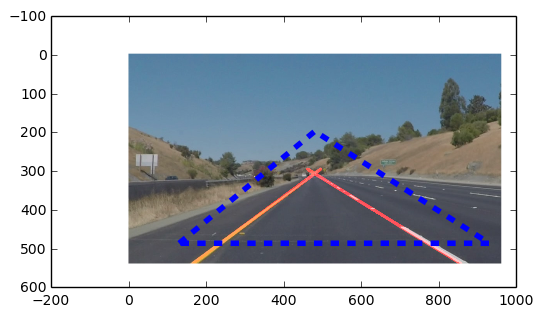

In [13]:
def process_image1(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    
    # grayscale the image
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    
    """
    plt.figure()
    plt.imshow(gray, cmap='gray');
    """
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 200
    high_threshold = 200
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Define a four sided polygon to mask
    imshape = image.shape
    center_x = int(imshape[1]/2)
    center_y = int(imshape[0]/2) + int(imshape[0]/20) - 100
    left_x = max(0,center_x - 350)
    right_x = min(center_x + 450, imshape[1])
    
    bottom_y = imshape[0] - int(imshape[0]/10)
    
    vertices = np.array([[(left_x,bottom_y),
                          (center_x, center_y), 
                          (center_x, center_y), 
                          (right_x,bottom_y)]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 75    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 180 #minimum number of pixels making up a line
    max_line_gap = 200  # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments       
    line_image =  hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)     

    """
    line_image1 =  hough_lines1(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    """
    
    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    try:
        """        
        lines_edges = weighted_img(line_image1, color_edges, α=0.8, β=1., λ=0.)
        plt.figure()
        plt.imshow(lines_edges)
        
        lines_edges = weighted_img(line_image, color_edges, α=0.8, β=1., λ=0.)
        plt.figure()
        """
        
        lines_edges = weighted_img(line_image, image, α=0.8, β=1., λ=0.)
        
        """    
        plt.figure()
        """
        plt.imshow(lines_edges)
        
        x = [vertices[0][i][0] for i in range(len(vertices[0]))]
        y = [vertices[0][i][1] for i in range(len(vertices[0]))]
        x.append(x[0])
        y.append(y[0])
        plt.plot(x, y, 'b--', lw=4)
        

    except:
        lines_edges = image
    
    return lines_edges
    
    
#Test!!!    
dir_name = "test_images/"
picl = os.listdir(dir_name)
fname = dir_name+picl[5]
#reading in an image
image = mpimg.imread(fname)  
process_image1(image);   

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:12<00:00, 19.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 12.5 s, sys: 460 ms, total: 12.9 s
Wall time: 13.7 s


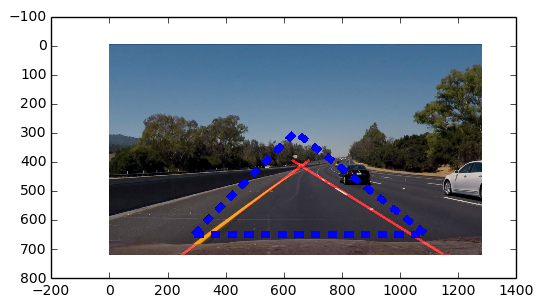

In [14]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
image = clip2.get_frame(2)
process_image1(image); 

challenge_clip = clip2.fl_image(process_image1)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# Reflections

A number of factors impact the detection of lane markers
* Masking polynomial : Close fitting results in loss of segments, while loose fit results in noise elements
* Lighting conditions : As the car drives thru different lighting conditions, grayscale image behaves differently and hence lanes tend to dissapear under certain conditions. hough transform parameters may need to be tweaked with changing lighting conditions.
* Shadows : Similar to lighting conditions, shadows under overpasses affect lane detection
* Color of the lanes : Color of lanes also impact lane detection under certain lighting conditions
* Hough Transform parameters : These are not a fixed universal constants..seem to be affected by other fators.. such as weather, lighting condition, environment. Making it non deterministic to drive the same vehicle under different environmental conditions.
* Multiple lane roads : Require changes to masking polynomial to avoid noise from other lanes

Many of these can be overcome with additional complexity, historic averaging and extrapolation of lanes using average slope and intercept. Even after several iterations, its not deterministic since environmental factors can impact the lane detection. Perhaps lanes and markers could be recorded under several conditions and deep learning can be applied to get a better prediction even under bad conditions.
Further, more tests need to be conducted for Night travel and travel under low light conditions.